In [1]:
import sys
sys.path.append("..")

In [38]:
from gymnasium.utils import seeding
import numpy as np

np_random, _ = seeding.np_random(0)

a = np_random.choice(["h", "f"], size=(10,10), p=[0.5, 0.5], shuffle=False)
b = np.empty(10, dtype="U1")
print(a.dtype, b.dtype)

a = ["".join(row) for row in a]
a

<U1 <U1


['fhhhffffff',
 'fhfhfhffhh',
 'hhfffhffff',
 'fhhffhhffh',
 'fhfhhfhfhf',
 'fhfhhhhfhh',
 'hhhfhfhfhh',
 'ffhfhhfffh',
 'fhffhfffhf',
 'ffhfffhfff']

obs.shape=(1, 16, 16), obs.dtype=dtype('uint8')


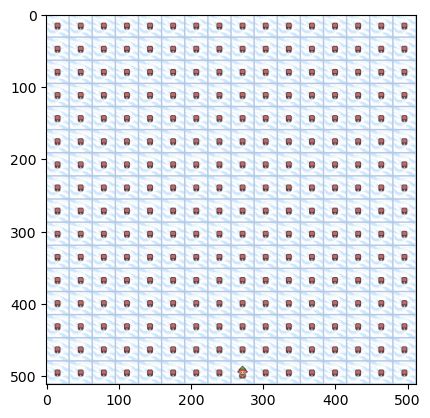

In [2]:
import matplotlib.pyplot as plt
from mango.environments import frozen_lake

init_kwargs = dict(
    map_name="RANDOM",
    size=16,
    p=0.9999,
    random_start=True,
    #mirror=True,
    hide_goal=True,
)
env = frozen_lake.CustomFrozenLakeEnv(**init_kwargs) #type: ignore
#env = frozen_lake.ReInitOnReset(env, **init_kwargs)
#env = frozen_lake.TensorObservation(env, one_hot=True)
env = frozen_lake.CoordinateObservation(env, one_hot=True)

env_shape = (env.unwrapped.ncol, env.unwrapped.nrow)  # type: ignore
obs, _ = env.reset()
print(f"{obs.shape=}, {obs.dtype=}")
plt.imshow(env.render()) #type: ignore
plt.show()

In [3]:
import torch
from mango.mango import Mango
from mango.actions.abstract_actions import Grid2dMovement, Grid2dActions

n_layers = 3
gamma = 0.5
mango = Mango(
    environment=env,
    abstract_actions=[
        Grid2dMovement(
            cell_shape=(2**i, 2**i),
            grid_shape=env_shape,
            agent_channel=0,
            reward=(1 - gamma),
            p_termination=0.1,
        )
        for i in range(1, n_layers)
    ],
    policy_params=dict(
        lr=1e-3,
        gamma=gamma,
        net_params=dict(
            hidden_channels=[16, 16],
            hidden_features=[256, 32],
            activation_out=torch.nn.Tanh(),
            device=torch.device("cuda") if torch.cuda.is_available() else None,
        ),
    ),
)
print(mango)

Mango(
  (1): MangoEnv(
    (environment): <CoordinateObservation<CustomFrozenLakeEnv instance>>
  )
  (2): MangoLayer(
    (abs_actions): Grid2dMovement(cell_shape=(2, 2), grid_shape=(16, 16), agent_channel=0, p_termination=0.1, reward=0.5)
    (policy): DQnetPolicyMapper(comand_space=Discrete(4), action_space=Discrete(4))
  )
  (3): MangoLayer(
    (abs_actions): Grid2dMovement(cell_shape=(4, 4), grid_shape=(16, 16), agent_channel=0, p_termination=0.1, reward=0.5)
    (policy): DQnetPolicyMapper(comand_space=Discrete(4), action_space=Discrete(4))
  )
)


In [4]:
from tqdm.notebook import tqdm
import numpy as np

N = 100
for randomness in (pbar := tqdm(np.linspace(1.0, 0.0, N) ** 2)):
    pbar.set_description(f"randomness: {randomness:.3f}")
    for layer in [1,2]:
        mango.set_randomness(randomness, layer=layer)
    mango.explore(episode_length=1)
    mango.train()

  0%|          | 0/100 [00:00<?, ?it/s]

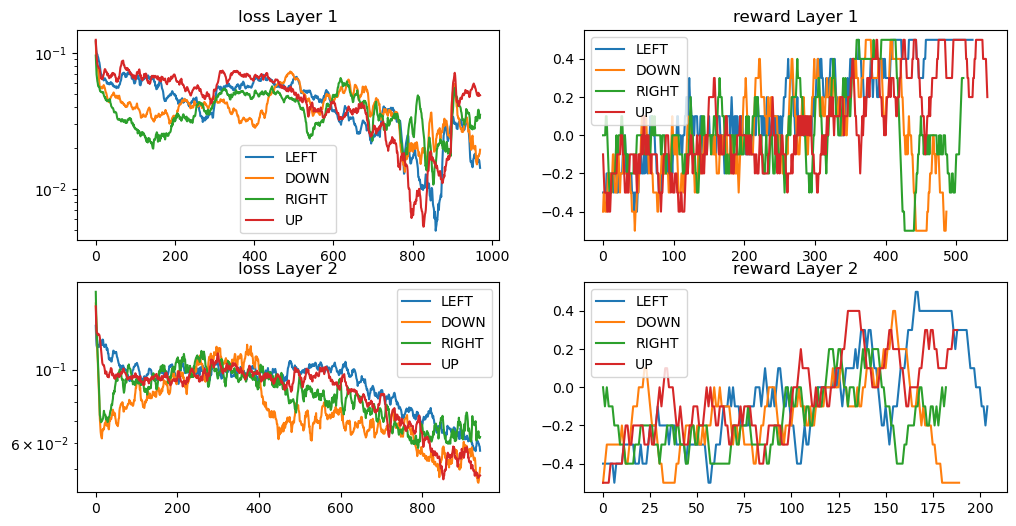

In [ ]:
from mango.utils import smooth

plt.figure(figsize=(12, 6))
for layer_idx, layer in enumerate(mango.abstract_layers, start=1):
    for action in Grid2dActions:
        plt.subplot(2, len(mango.abstract_layers), 2*(layer_idx-1)+1)
        plt.title(f"loss Layer {layer_idx}")
        plt.semilogy(smooth(layer.train_loss_log[action]), label=f"{action.name}")
        plt.legend()
    
        plt.subplot(2, len(mango.abstract_layers), 2*(layer_idx-1)+2)
        plt.title(f"reward Layer {layer_idx}")
        plt.plot(smooth(layer.intrinsic_reward_log[action]), label=f"{action.name}")
        plt.legend()

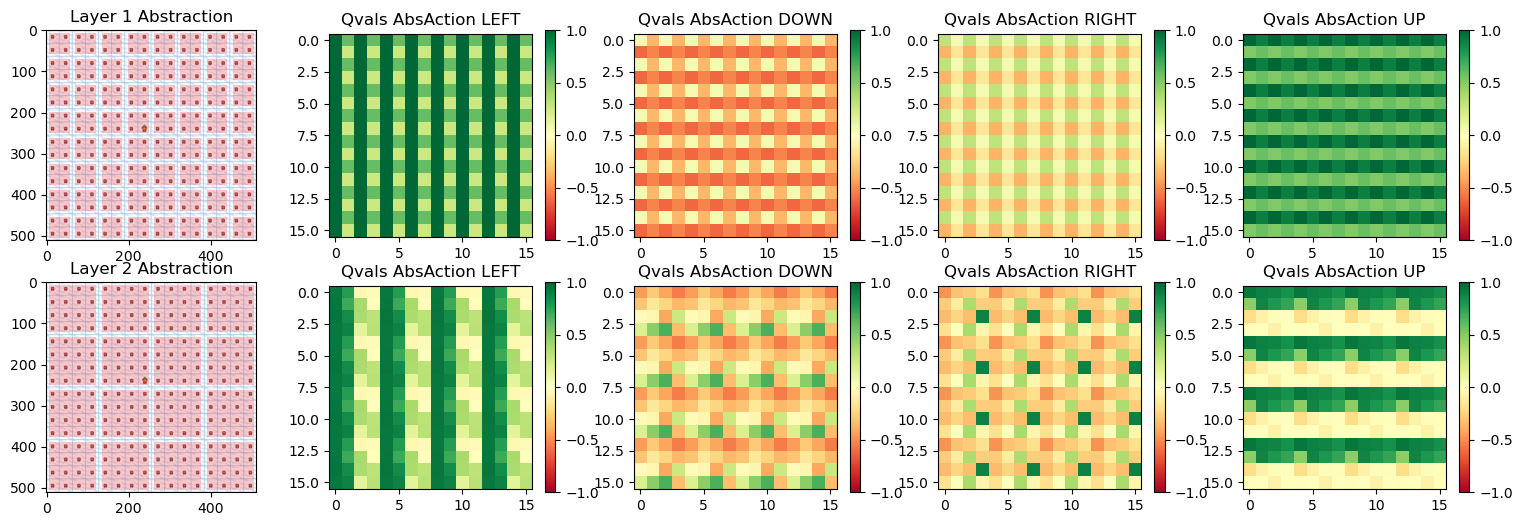

In [ ]:
from mango.utils import plot_grid, plot_trajectory, plot_qval_heatmap, ActType

obs, info = mango.reset()
trajectory = [obs]
for action in Grid2dActions:
    end_state, reward, trunc, term, info = mango.execute_option(
        layer=len(mango.layers)-1, action=ActType(action)
    )
    trajectory.extend(info["mango:trajectory"])

plt.figure(figsize=(4*len(Grid2dActions)+3, 3*len(mango.abstract_layers)))
for row, layer in enumerate(mango.abstract_layers):
    plt.subplot(len(mango.abstract_layers), len(Grid2dActions)+1, row * (len(Grid2dActions)+1) + 1)
    plt.title(f"Layer {row+1} Abstraction")
    plt.imshow(env.render())  # type: ignore
    #plot_trajectory(trajectory, env)
    plot_grid(env, layer.abs_actions.cell_shape) # type: ignore
    for col, action in enumerate(Grid2dActions, start=2):
        plt.subplot(len(mango.abstract_layers), len(Grid2dActions)+1, row * (len(Grid2dActions)+1) + col)
        plt.title(f"Qvals AbsAction {action.name}")
        plt.imshow(env.render())  # type: ignore
        policy = layer.policy.policies[ActType(action)]
        plot_qval_heatmap(policy, env, layer.abs_actions.mask, cmap="RdYlGn", vmin=-1, vmax=1)  # type: ignore